In [1]:
import numpy as np
import time
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.aqua import Operator, run_algorithm

import random
from math import log, pi

from born.particle import PSO

In [2]:
# function for creating a target distribution

class QuantumBornMachine:
    
    
    
    def __init__(self, num_qubits, num_shots, parameterize_cnot = False):
        
        # Use Aer's qasm_simulator
        # Aer uses local solver to perform simulation
        self.backend = Aer.get_backend('qasm_simulator')
        
        self.epsilon = 0.01  # Stops pso from diverging
        
        self.num_qubits = num_qubits
        self.num_shots = num_shots
        
        self.q = QuantumRegister(self.num_qubits)                  #can these be initialized outside the function?
        self.c = ClassicalRegister(self.num_qubits)
        self.circ = QuantumCircuit(self.q, self.c)
        
        self.parameterize_cnot = parameterize_cnot
        
    # Define layer of quantum circuit.
    # For now let's just parameterize the single qubit gates

    def rotations(self, circ, q, n, rotation_params):
        for i in range(n):
            circ.u3(rotation_params[2*i], rotation_params[2*i+1], 0, q[i])
            
    def fully_connected_cnot(self, circ, q, n):
        """ Fully-connected circuit cnot gate
        """
        for i in range(n):
            for j in range(n):
                if i != j:
                    circ.cx(q[i], q[j])
                
    def layer_normal(self, circ, q, n, params):
        self.rotations(circ, q, n, params)
        self.fully_connected_cnot(circ, q, n)
        return circ

    def fully_connected_cnot_parameterized(self, circ, q, n, FC_params):
        """ Parameterize cnot gate combinations in fully connected circuit
        """
        k = 0
        for i in range(n):
            for j in range(n):
                if i != j:
                    circ.crz(FC_params[k], q[i], q[j])
                    k += 1

    def layer_cnot_parameterized(self, circ, q, n, params):
        """
        params:
        q: python object used in Aer circuit backend
        n: number of qubits
        """
        rotation_params = params[:2*n]
        fully_connected_params = params[2*n : 2*n + n*(n-1)]
        self.rotations(circ, q, n, rotation_params)
        self.fully_connected_cnot_parameterized(circ, q, n, fully_connected_params)
        return circ


    def generate_bars_and_stripes(self, length, num_samples):
        """ Creates a dataset containing samples showing bars or stripes.
        :param length: Length of the bars/stripes.
        :type length: int
        :param num_samples: Number of samples
        :type num_samples: int
        :return: Samples.
        :rtype: numpy array [num_samples, length*length]
        """
        
        data = np.zeros((num_samples, length * length))
        for i in range(num_samples):
            values = np.dot(np.random.randint(low=0, high=2,
                                                  size=(length, 1)),
                              np.ones((1, length)))
            if np.random.random() > 0.5:
                values = values.T
            data[i, :] = values.reshape(length * length)
        return data

    def get_target(self, length, num_samples):
        """
        :param length: Length of the bars and stripes
        :type length: 
        """

        #    data ={
        #    '0000': 1/8,
        #    '0110': 1/4,
        #    '1001': 1/4,
        #    '0101': 1/8,
        #    '1010': 1/8,
        #    '1111': 1/8}
        #    return data


        target = {}
        data = self.generate_bars_and_stripes(length, num_samples)

        for sample in data:
            key = ''.join(map(str, [int(i) for i in sample]))

            if key not in target.keys():
                target[key] = 1
            else:
                target[key] += 1

        # Normalize target distribution before returning
        for key in target.keys():
            target[key] /= num_samples

        return target


    def get_cost(self, target, learned):
        """ Define the cost function, here being the KL divergence between the target and learned distributions
        """
        shots = self.num_shots
        cost = 0

        for key in learned:
            learned[key] /= shots     # normalize counts from measurements

        for key in target:
            if key not in learned:      
                learned[key] = 0         # adds any necessary keys to learned for which we got no counts        

            if target[key] != 0:
                cost += target[key]*(log(target[key]) - log(max(self.epsilon, learned[key])))

        return cost

    def cost_function(self, n, target, params, shots):
        learned = self.run_circuit(params)
        cost = self.get_cost(target, learned)

        return cost

    def run_circuit(self, params):
        """

        @params:
            n: int - number of qubits
            params: list - feature parameters
            shots: int - number of circuit measurements to take
        """
        
        n = self.num_qubits
        shots = self.num_shots
        q = self.q
        c = self.c
        circ = self.circ
        num_params = len(params)
        
        # Run with various cnot configurations at rotation sub-layer output
        # With no parameterization, cnot gates are fully connected at rotation sub-layer outputs
        
        if self.parameterize_cnot:
            num_perlayer = 2*n+n*(n-1)
            num_layers = int(num_params/num_perlayer)

            for k in range(num_layers):
                circ = self.layer_cnot_parameterized(circ, q, n, params[num_perlayer*k : num_perlayer*(k+1)])
        else:
            num_layers = int(num_params/(2*n))
    
            for k in range(num_layers):
                circ = self.layer_normal(circ, q, n, params[2*n*k : 2*n*(k+1)])
            
        for i in range(n):
            circ.measure(q[i], c[i])
            
        # Run quantum circuit simulation
        result = execute(circ, backend = self.backend, shots = shots)
        learned = result.result().get_counts(circ)

        return learned

    def hist(n, params, shots):
        learned = run_circuit(n, params, shots)
        plot_histogram(learned)

Initialize Quantum Born Machine
Generating targets
Setting initial condiitons
Performing PSO
Iteration 2: 0.932365
FINAL: 0.932365
Run quantum circuit
Output histogram


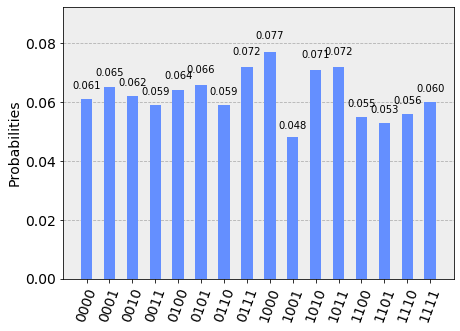

In [3]:
# Run QC training and optimization

def run_optimization(n = 4, layers = 2, shots = 1000, length = 2, num_samples = 1000, num_particles = 10):
    """
    params:
        n: number of qubits or data inputs
        layers: number of quantum circuit layers
        shots: shots per run of given circuit; larger will give better statistics from runs
        length: length of bars and stripes
        num_samples: number of target samples to generate
        num_particles: feature parameters in particle swarm
    """
    # What is this?
    #n = 3
    #distribution = np.random.rand(2**n)
    #distribution /= sum(distribution)
    
    print("Initialize Quantum Born Machine")
    qbm = QuantumBornMachine(num_qubits=n, num_shots=shots)

    print ("Generating targets")
    target = qbm.get_target(length=length, num_samples=num_samples)

    print("Setting initial condiitons")
    initial = np.random.normal(loc = pi, scale = pi/2, size=int((2*n+n*(n-1))*layers))

    print("Performing PSO")
    best = PSO(n, shots, target, qbm.cost_function, initial, num_particles=num_particles, maxiter=2).best()

    print("Run quantum circuit")
    learned = qbm.run_circuit(best)
    
    return learned

learned = run_optimization()
print("Output histogram")
plot_histogram(learned)

In [ ]:
target

In [ ]:
params = [4.952183907076087, 5.366143366803098, 6.1802748069211395, 5.423623009334368, 5.277995751340181, 4.9934647678469295]
learned = run_circuit(n, params, shots)
plot_histogram(learned)

In [ ]:
length = len(initial)
layers = int(length/(2*n))
layers

In [ ]:
n=3
k=0
initial

In [ ]:
initial[2*n*k : 2*n*(k+1)]

In [ ]:
n = 3
layers = 3

initial = np.random.normal(loc = pi, scale = pi/2, size=int((2*n+n*(n-1)/2)*layers))
initial

In [ ]:
initial[:6]

In [ ]:
initial[6:7]